In [2]:
import pandas as pd
df = pd.read_csv('./complaints5k.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-01-24,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",LA,70058.0,NaN,NaN,Web,2023-01-24,Closed with explanation,Yes,NaN,6473864
1,2023-03-03,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,CA,92345.0,NaN,NaN,Web,2023-03-03,In progress,Yes,NaN,6642105
2,2023-03-02,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,Experian Information Solutions Inc.,FL,33321.0,NaN,NaN,Web,2023-03-03,In progress,Yes,NaN,6639141
3,2023-03-03,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,NaN,NaN,Experian Information Solutions Inc.,GA,31324.0,NaN,NaN,Web,2023-03-03,In progress,Yes,NaN,6636773
4,2023-03-03,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,NaN,NaN,Experian Information Solutions Inc.,CA,94609.0,NaN,NaN,Web,2023-03-03,In progress,Yes,NaN,6636795


In [3]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 635 entries, 7 to 2983
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date received                 635 non-null    object 
 1   Product                       635 non-null    object 
 2   Sub-product                   635 non-null    object 
 3   Issue                         635 non-null    object 
 4   Sub-issue                     596 non-null    object 
 5   Consumer complaint narrative  635 non-null    object 
 6   Company public response       481 non-null    object 
 7   Company                       635 non-null    object 
 8   State                         634 non-null    object 
 9   ZIP code                      634 non-null    float64
 10  Tags                          56 non-null     object 
 11  Consumer consent provided?    635 non-null    object 
 12  Submitted via                 635 non-null    object 
 13  Date

In [5]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [6]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [7]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [8]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [9]:
df.head()

,Product,Consumer_complaint_narrative,category_id
7,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...,0
9,"Credit reporting, credit repair services, or o...",This company is still reporting on an account ...,0
28,"Credit reporting, credit repair services, or o...","ON XX/XX/2022, MY XX/XX/2022 RECORDED CALL FRO...",0
37,"Credit reporting, credit repair services, or o...",XXXX/ XXXX credit card balance was incorrectl...,0
38,"Credit reporting, credit repair services, or o...",My credit report contains a significant number...,0


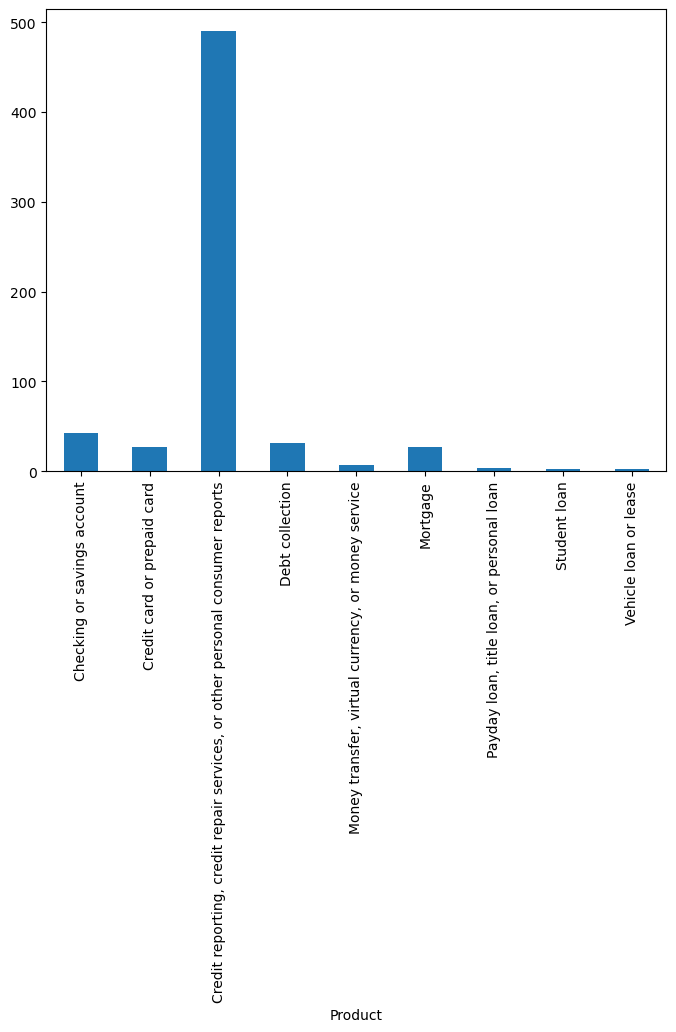

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(635, 2476)

In [13]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Checking or savings account':
  . Most correlated unigrams:
       . funds
       . bank
  . Most correlated bigrams:
       . wells fargo
       . checking account
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . charged
       . card
  . Most correlated bigrams:
       . credit card
       . 15 days
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
       . wells
       . fargo
  . Most correlated bigrams:
       . bank america
       . wells fargo
# 'Debt collection':
  . Most correlated unigrams:
       . validation
       . collection
  . Most correlated bigrams:
       . debt collection
       . collection company
# 'Money transfer, virtual currency, or money service':
  . Most correlated unigrams:
       . tax
       . compromised
  . Most correlated bigrams:
       . received email
       . case xxxx
# 'Mortgage':
  . Most correlated unigrams:
       . property
       . mortgage
  . Most cor

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [15]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [16]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [23]:
df[df['Consumer_complaint_narrative'].str.contains("I discovered that some of the information on my credit report was incorrect")]

,Product,Consumer_complaint_narrative,category_id
99,"Credit reporting, credit repair services, or o...",I discovered that some of the information on m...,0
1199,"Credit reporting, credit repair services, or o...",I discovered that some of the information on m...,0
2360,"Credit reporting, credit repair services, or o...",I discovered that some of the information on m...,0
2385,"Credit reporting, credit repair services, or o...",I discovered that some of the information on m...,0
2412,"Credit reporting, credit repair services, or o...",I discovered that some of the information on m...,0
2514,"Credit reporting, credit repair services, or o...",I discovered that some of the information on m...,0
2684,"Credit reporting, credit repair services, or o...",I discovered that some of the information on m...,0
2743,"Credit reporting, credit repair services, or o...",I discovered that some of the information on m...,0


In [24]:
df[df['Consumer_complaint_narrative'].str.contains("We refinanced our Wells Fargo mortgage with ")]

,Product,Consumer_complaint_narrative,category_id
1125,Mortgage,We refinanced our Wells Fargo mortgage with XX...,4


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/deepcode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/deepcode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/deepcode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/deepcode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


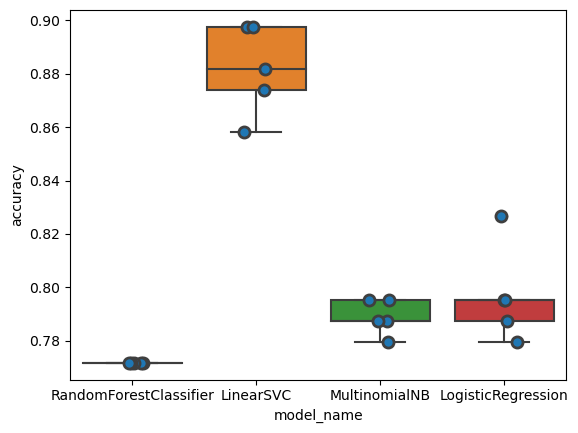

In [26]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [27]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.881890
LogisticRegression        0.796850
MultinomialNB             0.788976
RandomForestClassifier    0.771654
Name: accuracy, dtype: float64

In [28]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

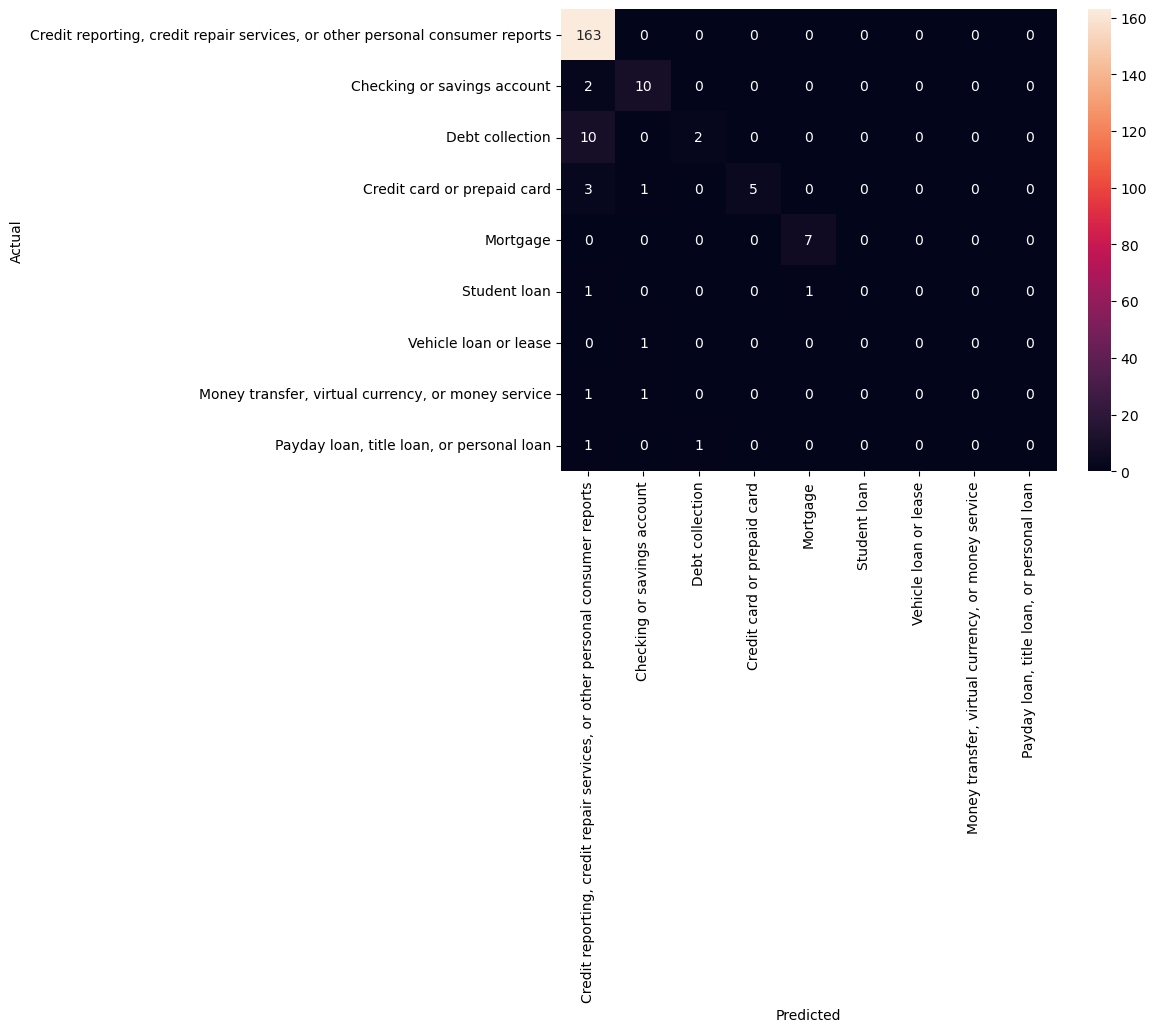

In [29]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [30]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 10 examples.


,Product,Consumer_complaint_narrative
2738,Debt collection,"please reference attachments for complaint, ex..."
2786,Debt collection,I was informed by my mortage company XXXX Newr...
1569,Debt collection,On XX/XX/22 I was contacted by ( XXXX ) XXXX a...
2967,Debt collection,Two weeks ago I received a notification/alert ...
1155,Debt collection,I need to dispute the account. This is not a b...
2771,Debt collection,To whom it may concern. \nPlease be advised th...
1754,Debt collection,"A letter dated XX/XX/XXXX from XXXX of Ohio, ..."
593,Debt collection,collection company added a closed account to m...
1995,Debt collection,I received an alert from XXXX XXXX XXXX XXXX X...
2440,Debt collection,After reviewing my credit profile on XX/XX/XXX...


In [31]:
model.fit(features, labels)

LinearSVC()

In [33]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Checking or savings account':
  . Top unigrams:
       . funds
       . deposit
  . Top bigrams:
       . check xxxx
       . checking account
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . charged
  . Top bigrams:
       . credit card
       . 15 days
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . report
       . transunion
  . Top bigrams:
       . credit report
       . xx 2021
# 'Debt collection':
  . Top unigrams:
       . collection
       . stating
  . Top bigrams:
       . collection company
       . xxxx stating
# 'Money transfer, virtual currency, or money service':
  . Top unigrams:
       . money
       . compromised
  . Top bigrams:
       . received email
       . case xxxx
# 'Mortgage':
  . Top unigrams:
       . mortgage
       . property
  . Top bigrams:
       . mortgage xxxx
       . payment xxxx
# 'Payday loan, title loan, or personal loan':
  . Top unigrams:
       . loan
  

In [34]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Checking or savings account'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Credit reporting, credit repair services, or other personal consumer reports'

"I can't get the money out of the country."
  - Predicted as: 'Checking or savings account'

"I have no money to pay my tuition"
  - Predicted as: 'Checking or savings account'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Credit reporting, credit repair services, or other personal consumer reports'



In [35]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.90      1.00      0.95       163
                                                 Checking or savings account       0.77      0.83      0.80        12
                                                             Debt collection       0.67      0.17      0.27        12
                                                 Credit card or prepaid card       1.00      0.56      0.71         9
                                                                    Mortgage       0.88      1.00      0.93         7
                                                                Student loan       0.00      0.00      0.00         2
                                                       Vehicle loan or lease       0.00      0.00      0.00         1
                          Money transfer, virtual curre

/home/deepcode/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/deepcode/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/deepcode/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
